# import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.impute import SimpleImputer
# from table_evaluator import load_data, TableEvaluator
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

# load data

In [2]:
# folder_path = 'gtfs'

# agency = pd.read_csv(f'{folder_path}/agency.txt')
# calendar = pd.read_csv(f'{folder_path}/calendar.txt')
# calendar_dates = pd.read_csv(f'{folder_path}/calendar_dates.txt')
# fare_attributes = pd.read_csv(f'{folder_path}/fare_attributes.txt')
# fare_rules = pd.read_csv(f'{folder_path}/fare_rules.txt')
# feed_info = pd.read_csv(f'{folder_path}/feed_info.txt')
# frequencies = pd.read_csv(f'{folder_path}/frequencies.txt')
# routes = pd.read_csv(f'{folder_path}/routes.txt')
# shapes = pd.read_csv(f'{folder_path}/shapes.txt')
# stops = pd.read_csv(f'{folder_path}/stops.txt')
# stop_times = pd.read_csv(f'{folder_path}/stop_times.txt')
# transfers = pd.read_csv(f'{folder_path}/transfers.txt')
# trips = pd.read_csv(f'{folder_path}/trips.txt')

In [3]:
# join map
# # Read GTFS CSV files
# agency = pd.read_csv('gtfs/agency.txt')
# stops = pd.read_csv('gtfs/stops.txt')
# routes = pd.read_csv('gtfs/routes.txt')
# trips = pd.read_csv('gtfs/trips.txt')
# stop_times = pd.read_csv('gtfs/stop_times.txt')
# calendar = pd.read_csv('gtfs/calendar.txt')
# routes_agency = routes.merge(agency, on='agency_id', how='left')
# trips_routes = trips.merge(routes_agency, on='route_id', how='left')
# stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='left')
# stop_times_trips_stops = stop_times_trips.merge(stops, on='stop_id', how='left')
# trips_calendar = trips.merge(calendar, on='service_id', how='left')
# joined_data = stop_times_trips_stops.merge(trips_calendar, on=['trip_id', 'route_id', 'service_id'], how='left', suffixes=('', '_y'))
# joined_data = joined_data.loc[:, ~joined_data.columns.str.endswith('_y')]
# joined_data.head()

In [4]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path)]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if not data.empty:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [5]:
# def preprocess(data_collection):
    # for k, v in data_collection.items():
    #     current_data = v.select_dtypes(include=[np.number]).astype(np.float32)
    #     scaler = StandardScaler()
    #     data_collection[k] = scaler.fit_transform(current_data)
    # return data_collection

In [6]:
def create_relation_dict(data_collection):
    relation_dict = {}
    for this_df_name, this_df in data_collection.items():
        this_df_dict = {}
        for this_col in this_df.columns:
            for that_df_name, that_df in data_collection.items():
                if that_df_name != this_df_name: # and that_df_name not in relation_dict.keys():
                    for that_col in that_df.columns:
                        if this_col == that_col and 'id' in this_col:
                            this_df_dict[that_df_name] = [this_col, that_col]
        relation_dict[this_df_name] = this_df_dict
    return relation_dict

In [7]:
raw_data_collection = load_data_collection("gtfs")

In [8]:
join_metadata = create_relation_dict(raw_data_collection)

In [9]:
join_metadata

{'agency': {'routes': ['agency_id', 'agency_id']},
 'calendar': {'calendar_dates': ['service_id', 'service_id'],
  'trips': ['service_id', 'service_id']},
 'calendar_dates': {'calendar': ['service_id', 'service_id'],
  'trips': ['service_id', 'service_id']},
 'feed_info': {},
 'routes': {'trips': ['route_id', 'route_id'],
  'agency': ['agency_id', 'agency_id']},
 'shapes': {'trips': ['shape_id', 'shape_id']},
 'stops': {'stop_times': ['stop_id', 'stop_id']},
 'stop_times': {'trips': ['trip_id', 'trip_id'],
  'stops': ['stop_id', 'stop_id']},
 'trips': {'routes': ['route_id', 'route_id'],
  'calendar': ['service_id', 'service_id'],
  'calendar_dates': ['service_id', 'service_id'],
  'stop_times': ['trip_id', 'trip_id'],
  'shapes': ['shape_id', 'shape_id']}}

# preprocess

In [10]:
def create_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [11]:
def preprocess_individual_data(data, preprocess_dict, factorization_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            data[col] = data[col].map(factorization_dict[col])
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col])
                            data[col] = (pd.to_datetime(cur_col) - timestamp).dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

In [12]:
def create_factorization_dict(data_collection, selected_columns):
    # Combine unique values from all DataFrames for each selected column
    unique_values = {}
    for col in selected_columns:
        local_unique_values = pd.concat([df[col] for df in data_collection.values() if col in df.columns]).unique()
        unique_values[col] = local_unique_values

    # Create a nested factorization dictionary
    factorization_dict = {}
    for col, local_unique_values in unique_values.items():
        factorization_dict[col] = {v: i for i, v in enumerate(local_unique_values)}

    return(factorization_dict)

In [13]:
features_to_factorize = ['agency_id','agency_name',
                         'agency_url','agency_timezone',
                         'agency_lang','service_id',
                        'feed_publisher_name','feed_publisher_url',
                        'feed_lang','feed_version',
                        'route_id','route_short_name',
                        'route_long_name','route_color',
                         'route_text_color','contract_id',
                        'shape_id','stop_id',
                        'stop_name','parent_station',
                        'platform_code','trip_id',
                        'stop_headsign','trip_headsign']
factorization_dict = create_factorization_dict(raw_data_collection, features_to_factorize)

## preprocess individual data

In [14]:
real_data_collection = {}

### agency

In [15]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id', 'agency_name','agency_url','agency_timezone','agency_lang']
preprocess_dict['transformation']['to_strip'] = ['agency_phone']
real_data_collection['agency'] = preprocess_individual_data(raw_data_collection['agency'], preprocess_dict, factorization_dict)

C:\Users\ouzho\AppData\Local\Temp\ipykernel_10376\2025635260.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\D', '').astype(int)


### calendar

In [16]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = preprocess_individual_data(raw_data_collection['calendar'], preprocess_dict, factorization_dict)

### calendar_dates

In [17]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = preprocess_individual_data(raw_data_collection['calendar_dates'], preprocess_dict, factorization_dict)

### feed_info

In [18]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['feed_publisher_name',
                                                  'feed_publisher_url',
                                                 'feed_lang',
                                                 'feed_version']
preprocess_dict['transformation']['to_elapsed_days'] = ['feed_start_date','feed_end_date']
real_data_collection['feed_info'] = preprocess_individual_data(raw_data_collection['feed_info'], preprocess_dict, factorization_dict)

### routes

In [19]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_short_name',
                                                 'route_long_name',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = preprocess_individual_data(raw_data_collection['routes'], preprocess_dict, factorization_dict)

### shapes

In [20]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['shape_id']
real_data_collection['shapes'] = preprocess_individual_data(raw_data_collection['shapes'], preprocess_dict, factorization_dict)

### stops

In [21]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','stop_name','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = preprocess_individual_data(raw_data_collection['stops'], preprocess_dict, factorization_dict)

### stop_times

In [22]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = preprocess_individual_data(raw_data_collection['stop_times'], preprocess_dict, factorization_dict)

### trips

In [23]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = preprocess_individual_data(raw_data_collection['trips'], preprocess_dict, factorization_dict)

## scaling

In [24]:
def batch_scaling(real_data_collection):
    scaled_data_collection = real_data_collection
    scaler_dict = {}
    columns_dict = {}
    for data_name, df in scaled_data_collection.items():
        columns_dict[data_name] = df.columns
        scaler = MinMaxScaler(feature_range = (-1,1))
        scaler_dict[data_name] = scaler
        scaled_data_collection[data_name] = scaler.fit_transform(df)
    return scaled_data_collection, scaler_dict, columns_dict

In [25]:
scaled_data_collection, scaler_collection, columns_dict = batch_scaling(real_data_collection)

In [26]:
columns_dict['agency'] = {'column_names':columns_dict['agency'],'primary_key':'agency_id'}
columns_dict['calendar'] = {'column_names':columns_dict['calendar'],'primary_key':'service_id'}
columns_dict['calendar_dates'] = {'column_names':columns_dict['calendar_dates'],'primary_key':'date'}
columns_dict['feed_info'] = {'column_names':columns_dict['feed_info'],'primary_key':'feed_publisher_url'}
columns_dict['routes'] = {'column_names':columns_dict['routes'],'primary_key':'route_id'}
columns_dict['shapes'] = {'column_names':columns_dict['shapes'],'primary_key':'shape_id'}
columns_dict['stops'] = {'column_names':columns_dict['stops'],'primary_key':'stop_id'}
columns_dict['stop_times'] = {'column_names':columns_dict['stop_times'],'primary_key':None}
columns_dict['trips'] = {'column_names':columns_dict['trips'],'primary_key':'trip_id'}

# Train GAN

## Sample & Noise Generation

In [27]:
def sample_data(data, size):
    return data[np.random.randint(0, data.shape[0], size)]

In [28]:
def generate_noise(n_samples, n_features):
    return np.random.uniform(-1, 1, (n_samples, n_features))

## Define Custom Setting (Wasserstein Loss)

In [29]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [30]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [31]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(discriminator_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, Discriminator, WGAN Function

In [32]:
def build_generator(input_dim, output_dim):
    model = models.Sequential()
    model.add(layers.Dense(units=128,
                           input_dim=input_dim,
                           kernel_initializer='he_uniform',
                           activation='LeakyReLU'))
    model.add(layers.BatchNormalization())
    # model.add(layers.Dense(units=64, activation='LeakyReLU'))
    # model.add(layers.Dense(units=64, activation='LeakyReLU'))
    model.add(layers.Reshape((4, 32)))
    model.add(layers.Conv1DTranspose(64,
                                     kernel_size=3,
                                     strides=2,
                                     padding="same",
                                     activation="LeakyReLU"))
    model.add(layers.Conv1DTranspose(32,
                                     kernel_size=3,
                                     strides=2,
                                     padding="same",
                                     activation="LeakyReLU"))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(units=output_dim, activation='tanh'))
    return model

In [33]:
def build_discriminator(input_dim, constraint_rate=0.01, optimization_rate=0.00005):
    clip_const = ClipConstraint(constraint_rate)
    rms_opt = optimizers.RMSprop(optimization_rate)
    model = models.Sequential()
    model.add(layers.Dense(128,
                           input_dim=input_dim,
                           kernel_initializer='he_uniform',
                           kernel_constraint=clip_const,
                           activation='LeakyReLU'))
    model.add(layers.BatchNormalization())
    model.add(layers.Reshape((4, 32)))
    model.add(layers.Conv1D(64,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            kernel_constraint=clip_const,
                            activation="LeakyReLU"))
    # model.add(layers.Conv1D(64,
    #                         kernel_size=4,
    #                         strides=2,
    #                         padding="same",
    #                         kernel_constraint=clip_const,
    #                         activation="LeakyReLU"))
    # model.add(layers.Dense(64, kernel_constraint=clip_const, activation='LeakyReLU'))
    # model.add(layers.Dense(64, kernel_constraint=clip_const, activation='LeakyReLU'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(units=1, activation='linear'))
    model.compile(loss=wasserstein_loss,
                  optimizer=rms_opt, metrics=['accuracy'])
    return model

In [34]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss=wasserstein_loss,
                 optimizer='adam')
    return model

## Define Training Strategy

In [35]:
def train_gan(scaled_data_collection, epochs=10, batch_size=128, seed=123):
    generator_collection = {}
    shape_info_collection = {}
    logs = []
    
    for k, v in scaled_data_collection.items():
        random.seed(seed)
        generator_log = []
        discriminator_log = []
        real_data = v
        n_features = real_data.shape[1]
        shape_info_collection[k] = real_data.shape
        
        generator = build_generator(n_features, n_features)
        discriminator = build_discriminator(n_features)
        gan = build_gan(generator, discriminator)
        
        for epoch in range(epochs):
            
            noise = generate_noise(batch_size, n_features)
            
            X_real = sample_data(real_data, batch_size)
            X_fake = generator.predict(noise)
            y_real = -1 * np.ones((batch_size, 1))
            y_fake = np.ones((batch_size, 1))
            
            d_loss_real, _ = discriminator.train_on_batch(X_real, y_real)
            d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = gan.train_on_batch(noise, y_real)
            generator_log.append(g_loss)
            discriminator_log.append(d_loss)
            # if epoch % 10 == 0:
            print(f"Dataset: \"{k}\" [Epoch: {epoch}] [D loss: {np.round(d_loss, 3)}] [G loss: {np.round(g_loss, 3)}]")
        logs.append([k, generator_log,discriminator_log])
        generator_collection[k] = generator
    plot_history(logs)   
    return generator_collection

## Train WGAN

Dataset: "agency" [Epoch: 0] [D loss: -0.005] [G loss: -0.0]
Dataset: "agency" [Epoch: 1] [D loss: 0.024] [G loss: -0.001]
Dataset: "agency" [Epoch: 2] [D loss: -0.03] [G loss: -0.001]
Dataset: "agency" [Epoch: 3] [D loss: -0.063] [G loss: -0.002]
Dataset: "agency" [Epoch: 4] [D loss: -0.082] [G loss: -0.002]
Dataset: "agency" [Epoch: 5] [D loss: -0.108] [G loss: -0.003]
Dataset: "agency" [Epoch: 6] [D loss: -0.141] [G loss: -0.003]
Dataset: "agency" [Epoch: 7] [D loss: -0.145] [G loss: -0.003]
Dataset: "agency" [Epoch: 8] [D loss: -0.169] [G loss: -0.003]
Dataset: "agency" [Epoch: 9] [D loss: -0.187] [G loss: -0.003]
Dataset: "calendar" [Epoch: 0] [D loss: 0.077] [G loss: -0.002]
Dataset: "calendar" [Epoch: 1] [D loss: 0.049] [G loss: -0.003]
Dataset: "calendar" [Epoch: 2] [D loss: -0.05] [G loss: -0.004]
Dataset: "calendar" [Epoch: 3] [D loss: -0.09] [G loss: -0.006]
Dataset: "calendar" [Epoch: 4] [D loss: -0.151] [G loss: -0.006]
Dataset: "calendar" [Epoch: 5] [D loss: -0.183] [G lo

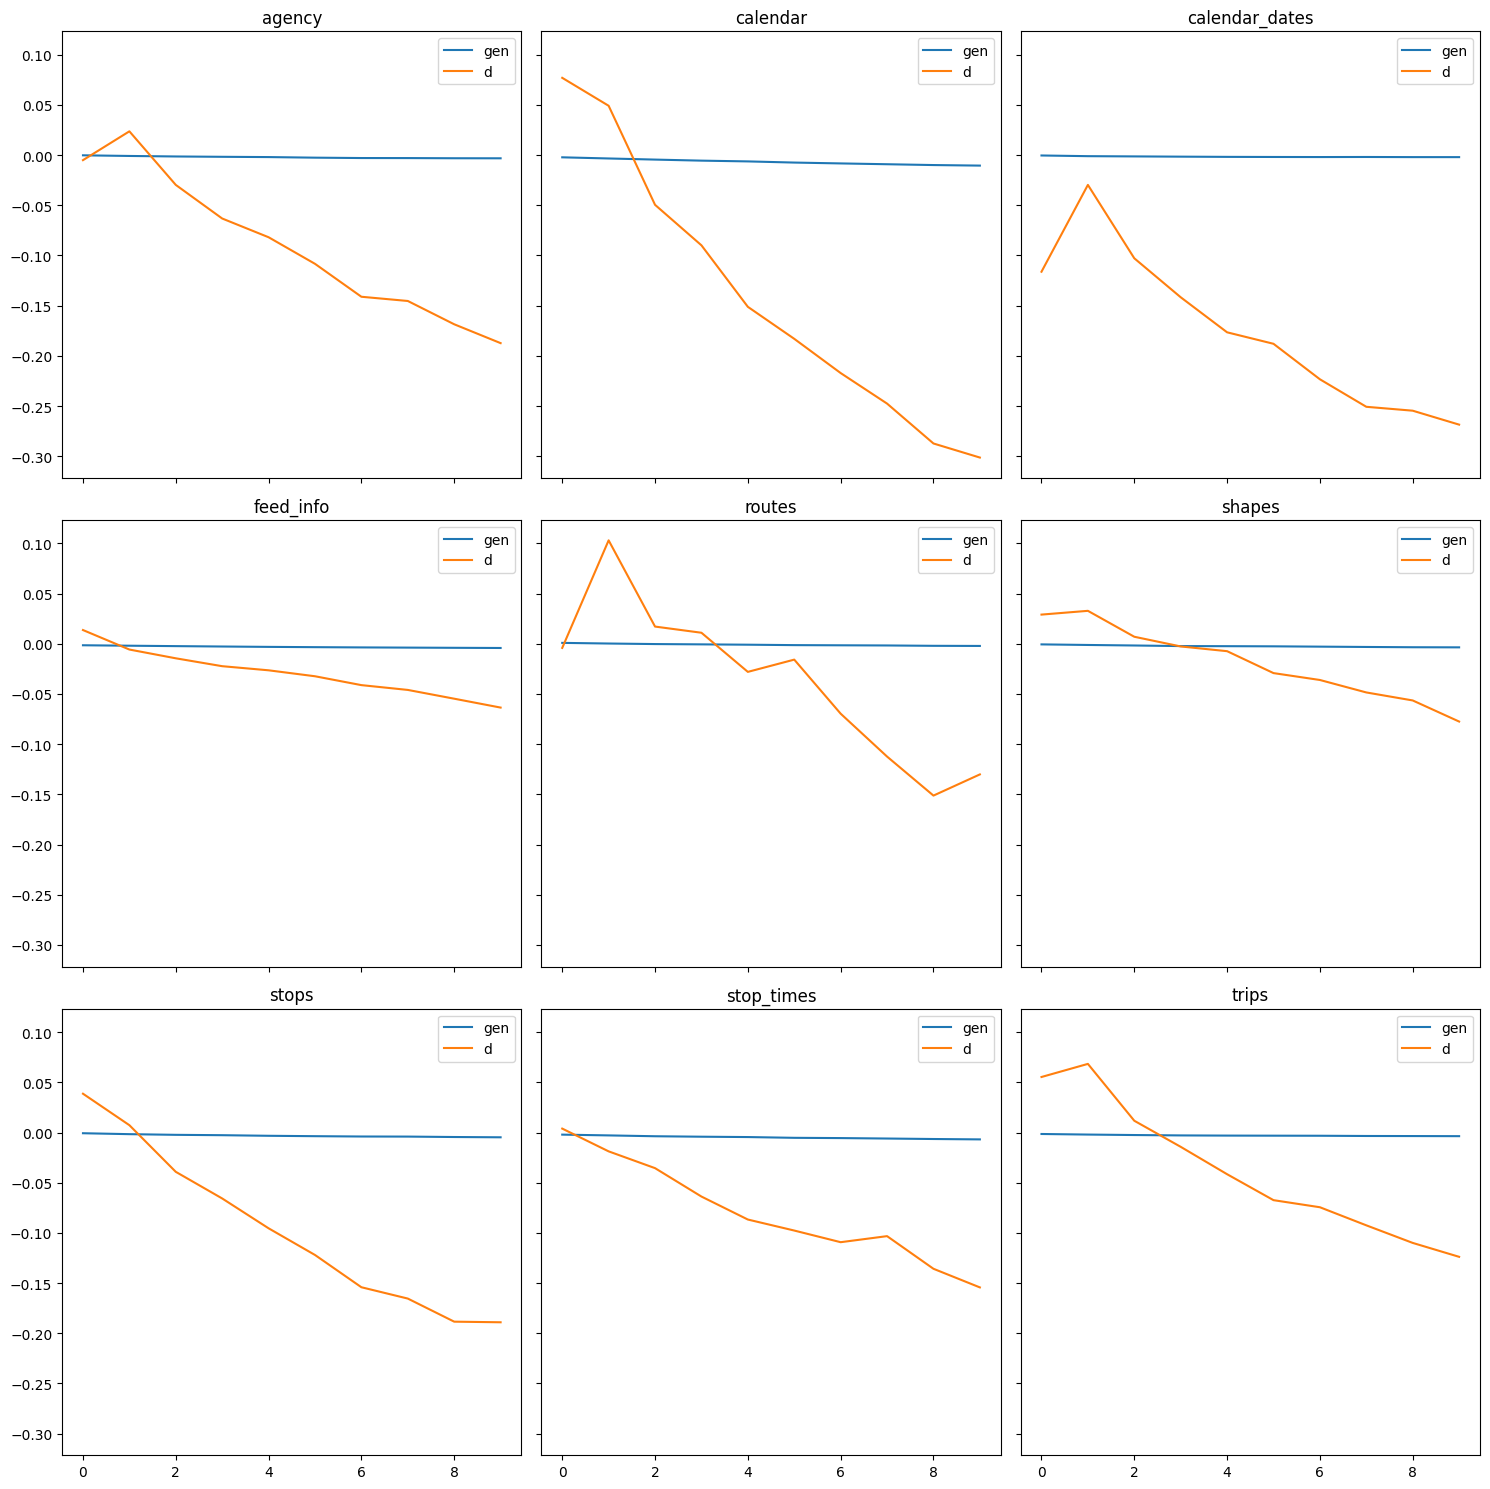

In [36]:
generator_collection = train_gan(scaled_data_collection)

# Synthetic Data Generation and Reverse-Transformation

In [37]:
# def generate_synthetic_tables(generators, join_metadata, columns_dict, scalers, rows_to_generate):
#     synthetic_data = {}
#     for table_name, generator in generators.items():
#         if isinstance(rows_to_generate, int):
#             n_rows = rows_to_generate
#         elif isinstance(rows_to_generate, dict):
#             n_rows = rows_to_generate[table_name]
#         else:
#             raise ValueError("rows_to_generate must be either an int or a dict")

#         noise = np.random.normal(0, 1, (n_rows, generator.input_shape[1]))
#         synthetic_rows = generator.predict(noise)

#         synthetic_rows = scalers[table_name].inverse_transform(synthetic_rows)

#         synthetic_table = pd.DataFrame(synthetic_rows, columns=columns_dict[table_name])
        
#         for col in synthetic_table.columns:
#             if 'id' in col:
#                 synthetic_table[col] = synthetic_table[col].round().astype(int)

#         synthetic_data[table_name] = synthetic_table

#     for table_name, related_tables in join_metadata.items():
#         for related_table_name, (table_key, related_table_key) in related_tables.items():
#             synthetic_data[table_name] = pd.merge(synthetic_data[table_name],
#                                                   synthetic_data[related_table_name],
#                                                   left_on=table_key,
#                                                   right_on=related_table_key,
#                                                   suffixes=('', f'_{related_table_name}'))

#     return synthetic_data

In [38]:
# def generate_synthetic_tables(generators, join_metadata, columns_dict, scalers, rows_to_generate):
#     synthetic_data = {}
#     key_mappings = {}
    
#     for table_name, generator in generators.items():
#         if isinstance(rows_to_generate, int):
#             n_rows = rows_to_generate
#         elif isinstance(rows_to_generate, dict):
#             n_rows = rows_to_generate[table_name]
#         else:
#             raise ValueError("rows_to_generate must be either an int or a dict")


#         noise = np.random.normal(0, 1, (n_rows, generator.input_shape[1]))
#         synthetic_rows = generator.predict(noise)

#         synthetic_rows = scalers[table_name].inverse_transform(synthetic_rows)

#         synthetic_table = pd.DataFrame(synthetic_rows, columns=columns_dict[table_name])

#         for col in synthetic_table.columns:
#             if 'id' in str(col):
#                 synthetic_table[col] = synthetic_table[col].round().astype(int)

#         synthetic_data[table_name] = synthetic_table

#     for table_name, related_tables in join_metadata.items():
#         for related_table_name, (table_key, related_table_key) in related_tables.items():
#             if table_key not in key_mappings:

#                 key_mappings[table_key] = synthetic_data[table_name][table_key].unique()

#             synthetic_data[related_table_name][related_table_key] = np.random.choice(
#                 key_mappings[table_key],
#                 size=len(synthetic_data[related_table_name])
#             )

#     return synthetic_data

In [39]:
def generate_synthetic_tables(generators, join_metadata, columns_dict, scalers, features_to_factorize, rows_to_generate):
    synthetic_data = {}
    key_mappings = {}
    
    # check if `rows_to_generate` is a number or dictionary
    # if it's a nmber, generate equal number of rows for all tables.
    # if it's a dict, generate corresponding number of rows, useful for table with id as primary key.
    for table_name, generator in generators.items():
        if isinstance(rows_to_generate, int):
            n_rows = rows_to_generate
        elif isinstance(rows_to_generate, dict):
            n_rows = rows_to_generate[table_name]
        else:
            raise ValueError("rows_to_generate must be either an int or a dict")

        # generate synthetic data
        noise = np.random.normal(0, 1, (n_rows, generator.input_shape[1]))
        synthetic_rows = generator.predict(noise)
        
        # reverse transformation
        synthetic_rows = scalers[table_name].inverse_transform(synthetic_rows)

        # convert to dataframe, add column header for join relation check
        synthetic_table = pd.DataFrame(synthetic_rows, columns=columns_dict[table_name]['column_names'])
        
        # convert primary keys to factor
        for col in synthetic_table.columns:
            if col in features_to_factorize:
                synthetic_table[col] = synthetic_table[col].round().astype(int)

        # make the primary key columns unique
        primary_key = columns_dict[table_name]['primary_key']
        if primary_key is not None:
            synthetic_table[primary_key] = np.arange(1, len(synthetic_table) + 1)

        synthetic_data[table_name] = synthetic_table

    # relation mapping
    for table_name, related_tables in join_metadata.items():
        # iterate each table, use primary key as reference, map the foreign key
        for related_table_name, (table_key, related_table_key) in related_tables.items():
            # ensure and make the primary key column unique
            if table_key not in key_mappings:
                key_mappings[table_key] = synthetic_data[table_name][table_key].unique()
            
            # ensure the foreign key exist from the parent table
            # map foreign key from the parent primary key
            synthetic_data[related_table_name][related_table_key] = np.random.choice(
                key_mappings[table_key],
                size=len(synthetic_data[related_table_name] )
            )

    return synthetic_data

In [40]:
rows_to_generate = {k:v.shape[0] for k,v in raw_data_collection.items()}

synthetic_data_collection = generate_synthetic_tables(generator_collection, join_metadata, columns_dict, scaler_collection, features_to_factorize, rows_to_generate)

In [41]:
synthetic_data_collection

{'agency':     agency_id  agency_name  agency_url  agency_timezone  agency_lang  \
 0           2            3           1                1            1   
 1           9            5           1                1            1   
 2           1            8           1                1            1   
 3          15            2           1                1            1   
 4          12            6           1                1            1   
 5           6            4           1                0            1   
 6           3            3           1                1            1   
 7          14           10           1                1            1   
 8           8            3           1                1            1   
 9           2            4           1                0            1   
 10          1            6           1                1            1   
 11          5            4           1                0            1   
 12          6            7           1  